# Donglin Wang Data Role Submission
This is the submission for the data role at EQ Work. I used the PySpark option as the main framework for my solution. 

## 0. Importing dependencies and datasets

In [1]:
import os
import math
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler

In [2]:
spark = SparkSession.builder.master('local').getOrCreate()
requests = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/DataSample.csv'))
pois = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/POIList.csv'))

## 1. Filtering out questionable requests
In the cell below, I first used a group function to gather all the requests that have unique time, latitude, and longitude. I then joined this grouped table with the original dataset to obtain a list of the safe requests.

In [3]:
def get_safe_requests(df, criteria):
    count_table = df.groupBy(criteria).count().where("count = 1")
    filtered = df.join(
        count_table, criteria
    ).select(df["*"])
    return filtered

criteria = [" TimeSt", "Latitude", "Longitude"]
filtered_reqs = get_safe_requests(requests, criteria)
filtered_reqs.show()

+-------+--------------------+-------+--------+------------+--------+---------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|
+-------+--------------------+-------+--------+------------+--------+---------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London| 42.9399| -81.2709|
|4516550|2017-06-21 15:00:...|     CA|      ON|      Guelph| 43.5776| -80.2201|
|4516600|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773|
|4516613|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773|
|4516693|2017-06-21 14:00:...|     CA|      ON|   Kitchener| 43.4381| -80.5099|
|4516771|2017-06-21 10:00:...|     CA|      ON|      Sarnia|  42.961|  -82.373|
|4516915|2017-06-21 15:00:...|     CA|      ON|      London| 43.0091| -81.1765|
|4516953|2017-06-21 16:00:...|     CA|      ON|   Kitchener| 43.4278| -80.5135|
|4516966|2017-06-21 01:00:...|     CA|  

## 2. Assigning each request to a POI
In the cell below, I assigned each request to the POI that they are closest to. **I noticed that POI1 and POI2 are identical. Therefore, I only assigned requests to POI1.**

In [4]:
def assign_poi(requests, pois):
    
    def dist(long_x, lat_x, long_y, lat_y):
        return acos(
            sin(toRadians(lat_x)) * sin(toRadians(lat_y)) + 
            cos(toRadians(lat_x)) * cos(toRadians(lat_y)) * 
                cos(toRadians(long_x) - toRadians(long_y))
        ) * lit(6371.0)

    pois = pois.toDF("POIID", "POI_Latitude","POI_Longitude")
    dist_table = requests.crossJoin(pois)
    dist_table = dist_table.withColumn("Distance", dist(dist_table["Longitude"], dist_table["Latitude"], \
                                           dist_table["POI_Longitude"], dist_table["POI_Latitude"]))
    dist_window = Window.partitionBy(dist_table["_ID"]).orderBy("Distance")
    assign_table = dist_table.withColumn("Distance_Rank", row_number().over(dist_window))\
                    .select(["_ID", "Distance", "Distance_Rank", "POIID"])\
                    .where("Distance_Rank = 1")\
                    .drop("Distance_Rank")
    return assign_table

assign_table = assign_poi(filtered_reqs, pois)
assign_table.show()

+-------+------------------+-----+
|    _ID|          Distance|POIID|
+-------+------------------+-----+
|4517905| 832.9559044776602| POI3|
|4526426|219.46152613302212| POI3|
|4535091| 279.5544969402128| POI1|
|4545807|489.24993432136375| POI3|
|4559622|273.46970531513176| POI3|
|4566292|  522.859880059124| POI3|
|4627121| 543.7619035266968| POI3|
|4641250| 575.3734521671146| POI4|
|4642240|11.787141911666764| POI1|
|4655592|281.68360939878573| POI1|
|4658793|  522.019302021386| POI3|
|4670539| 297.8335446811667| POI1|
|4670861| 279.4649002371354| POI1|
|4700696| 536.8740990194277| POI3|
|4747687| 279.4649002371354| POI1|
|4763768|277.12477385588113| POI1|
|4771855|496.34922110135346| POI3|
|4792728|11.870730699715196| POI1|
|4800265| 269.7406912064529| POI3|
|4807712|11.787141911666764| POI1|
+-------+------------------+-----+
only showing top 20 rows



## 3. Calculate statistics about the POI assignments
In the cell below, I calculated the average, standard deviation, enclosing circle radius, and request density for each POI.

In [5]:
poi_stat_table = assign_table.groupBy("POIID")
print("Average distance for each Point of Interest")
poi_stat_table.avg("Distance").show()
print("The radius of circle enclosing all requests for each Point of Interest")
poi_stat_table.max("Distance").show()
print("Standard deviation of distance for each Point of Interest")
poi_stat_table.agg(stddev("Distance")).show()
print("Request density for each Point of Interest")
poi_counts = poi_stat_table.agg(count("POIID").alias("Count"))
poi_radius = poi_stat_table.agg(max("Distance").alias("Radius"))
poi_density = poi_counts.join(poi_radius, "POIID")
poi_density.withColumn("Density", poi_density["Count"] / (poi_density["Radius"] ** 2 * math.pi)).show()

Average distance for each Point of Interest
+-----+------------------+
|POIID|     avg(Distance)|
+-----+------------------+
| POI4| 514.9971719812286|
| POI1|300.71474756868054|
| POI3| 451.6511492015015|
+-----+------------------+

The radius of circle enclosing all requests for each Point of Interest
+-----+------------------+
|POIID|     max(Distance)|
+-----+------------------+
| POI4| 9349.572770487366|
| POI1|11531.820831836454|
| POI3|1474.5809620285709|
+-----+------------------+

Standard deviation of distance for each Point of Interest
+-----+---------------------+
|POIID|stddev_samp(Distance)|
+-----+---------------------+
| POI4|   1506.8899707703208|
| POI1|   388.27338526354424|
| POI3|   223.63174183104917|
+-----+---------------------+

Request density for each Point of Interest
+-----+-----+------------------+--------------------+
|POIID|Count|            Radius|             Density|
+-----+-----+------------------+--------------------+
| POI4|  422| 9349.572770487366

## 4a. Analyze and model the data
### 4a.1
In the cel below, I have put the request distance for each of the points of interest into a box plot. 
According to the documentation of pandas.DataFrame.boxplot, the edges of the box indicates the 1st (Q1) and 3rd (Q3) quartile of the distances while the line in the middle is the median. The whisker extends outward by no more than 1.5 * (Q3 - Q1), meaning that any points that lie outside Q1 - 1.5 * (Q3 - Q1) or Q3 + 1.5 * (Q3 - Q1) would be outside of the top and bottom whisker. As we can see, both POI1 and POI4 have a lot of outliers that are a lot further to the POI then the rest of the requests, whereas the distance distribution for POI3 spread more evenly. 

<AxesSubplot:title={'center':'Distances between POI4 and its assigned requests'}>

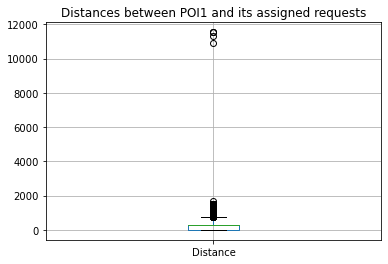

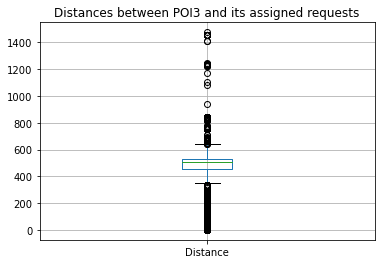

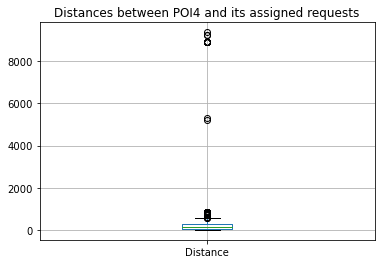

In [6]:
poi1_distance = assign_table.select(["Distance"]).where('POIID = "POI1"')
poi3_distance = assign_table.select(["Distance"]).where('POIID = "POI3"')
poi4_distance = assign_table.select(["Distance"]).where('POIID = "POI4"')
plt.title("Distances between POI1 and its assigned requests")
poi1_distance.toPandas().boxplot("Distance")
plt.figure()
plt.title("Distances between POI3 and its assigned requests")
poi3_distance.toPandas().boxplot("Distance")
plt.figure()
plt.title("Distances between POI4 and its assigned requests")
poi4_distance.toPandas().boxplot("Distance")

Seeing that a lot of requests for POI1 and POI4 are outliers, I chose to filter out requests that are further than 2000 km away from the point of interest. The resulting box plot looks like this:

<AxesSubplot:>

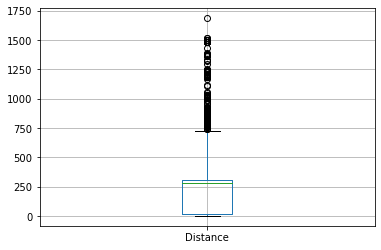

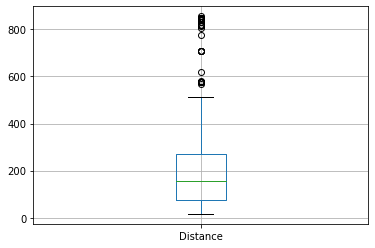

In [7]:
poi1_distance = poi1_distance.select(["Distance"]).where("Distance < 2000")
poi4_distance = poi4_distance.select(["Distance"]).where("Distance < 2000")
poi1_distance.toPandas().boxplot("Distance")
plt.figure()
poi4_distance.toPandas().boxplot("Distance")

After removing the outliers, I then calculated the score. Given a POI indexed by $j$ with $n$ requests $\{d_{1,j}, ..., d_{n,j}\}$, the score $score_{i,j}$ for the $i$th point is:
$$score_{i,j} = 1 - \frac{d_{i,j}}{max\{d_{1,j}, ..., d_{n,j}\} - min\{d_{1,j}, ..., d_{n,j}\}} \times 20 - 10$$
The cell below shows the histogram plot for the scores of each POI:

<Figure size 432x288 with 0 Axes>

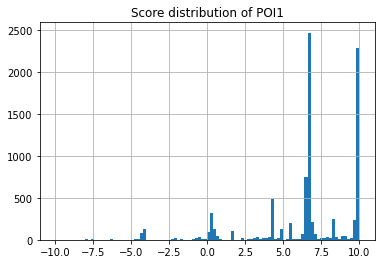

<Figure size 432x288 with 0 Axes>

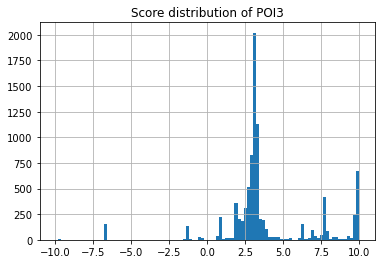

<Figure size 432x288 with 0 Axes>

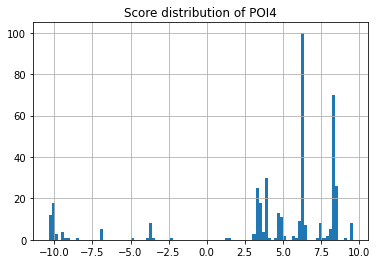

<Figure size 432x288 with 0 Axes>

In [8]:
def calc_normalized_dist(df, col_name):
    col_min = df.agg({col_name: "min"}).collect()[0][0]
    col_max = df.agg({col_name: "max"}).collect()[0][0]
    return df.withColumn("Score",  (1 - poi1_distance[col_name] / (col_max - col_min)) * 20 - 10)

poi1_scores = calc_normalized_dist(poi1_distance, "Distance")
poi3_scores = calc_normalized_dist(poi3_distance, "Distance")
poi4_scores = calc_normalized_dist(poi4_distance, "Distance")

poi1_scores.toPandas().hist("Score", bins=100)
plt.title("Score distribution of POI1")
plt.figure()
poi3_scores.toPandas().hist("Score", bins=100)
plt.title("Score distribution of POI3")
plt.figure()
poi4_scores.toPandas().hist("Score", bins=100)
plt.title("Score distribution of POI4")
plt.figure()

To see the best which POI performs the best, I calculated the median and average scores for each POI in the cell below:

In [9]:
print("Average score for POI1")
poi1_scores.select(avg("Score").alias("Mean Score")).show()
print("Average score for POI3")
poi3_scores.select(avg("Score").alias("Mean Score")).show()
print("Average score for POI4")
poi4_scores.select(avg("Score").alias("Mean Score")).show()
print("Median score for POI1")
poi1_scores.select(percentile_approx("Score", 0.5)).show()
print("Median score for POI3")
poi3_scores.select(percentile_approx("Score", 0.5)).show()
print("Median score for POI4")
poi4_scores.select(percentile_approx("Score", 0.5)).show()

Average score for POI1
+------------------+
|        Mean Score|
+------------------+
|6.5044824305772835|
+------------------+

Average score for POI3
+------------------+
|        Mean Score|
+------------------+
|3.8708121626795116|
+------------------+

Average score for POI4
+------------------+
|        Mean Score|
+------------------+
|4.2096371714769925|
+------------------+

Median score for POI1
+------------------------------------+
|percentile_approx(Score, 0.5, 10000)|
+------------------------------------+
|                   6.704192344882234|
+------------------------------------+

Median score for POI3
+------------------------------------+
|percentile_approx(Score, 0.5, 10000)|
+------------------------------------+
|                  3.1469643103559655|
+------------------------------------+

Median score for POI4
+------------------------------------+
|percentile_approx(Score, 0.5, 10000)|
+------------------------------------+
|                   6.256832244977197|

It would appear that POI1 most accurately captures the requests nearby.

### 4a.2
For this part, I hypothesize another set of Points of Interests that would better capture the distribution of requests. I used the K-mean clustering algorithm to come up with the new set of coordinates. In addition, because there are many outliers in the bar graph, I used 4 points of interest instead of 3 to cover the outliers resulting from having only 3 POIs

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [11]:
assembler = VectorAssembler(
    inputCols=["Latitude", "Longitude"],
    outputCol="features"
)
trainingData = assembler.transform(requests).select("features")
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(trainingData)
for center in model.clusterCenters():
    print(center)

[  51.92495071 -113.35158346]
[ 43.91390492 -79.95142058]
[25.1319348 72.1377144]
[ 45.67683094 -71.91334253]


In [12]:
new_pois = ()
for i, (lat, long) in enumerate(model.clusterCenters()):
    new_pois = new_pois + (("POI%s"%(i+1), float(lat), float(long)), )

columns = ["POIID", "POI_Latitude", "POI_Longitude"]
new_pois = spark.createDataFrame(data = new_pois, schema = columns)
new_pois.show()

+-----+------------------+-------------------+
|POIID|      POI_Latitude|      POI_Longitude|
+-----+------------------+-------------------+
| POI1|51.924950713012386|-113.35158346374011|
| POI2|  43.9139049192433| -79.95142058260134|
| POI3| 25.13193480000001|  72.13771439999998|
| POI4| 45.67683093901952| -71.91334253273482|
+-----+------------------+-------------------+



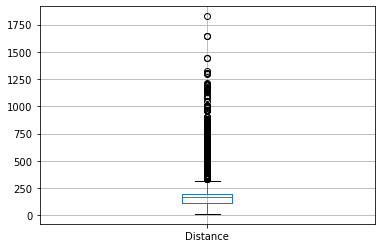

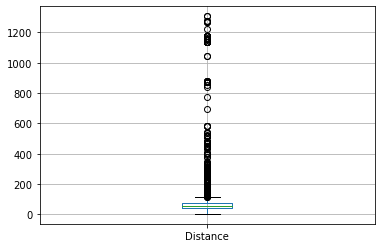

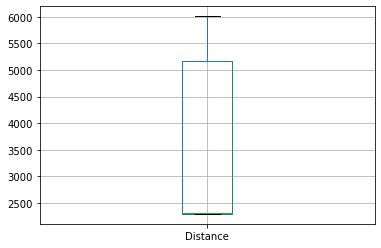

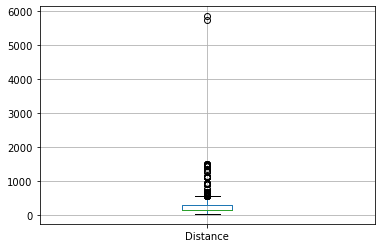

<Figure size 432x288 with 0 Axes>

In [13]:
new_assign_table = assign_poi(filtered_reqs, new_pois)
for i in range(1, 5):
    new_assign_table.select("Distance").where('POIID = "POI%d"' % i).toPandas().boxplot()
    plt.figure()

As we can see, aside from one POI where the maximum distance reaches around 6000km, all of the POIs now have distances below 2000 km. The cell below provides some statistics for the new POIS:

In [14]:
poi_stat_table = new_assign_table.groupBy("POIID")
print("Average distance for each NEW Point of Interest")
poi_stat_table.avg("Distance").show()
print("The radius of circle enclosing all requests for each NEW Point of Interest")
poi_stat_table.max("Distance").show()
print("Standard deviation of distance for each NEW Point of Interest")
poi_stat_table.agg(stddev("Distance")).show()
print("Request density for each NEW Point of Interest")
poi_counts = poi_stat_table.agg(count("POIID").alias("Count"))
poi_radius = poi_stat_table.agg(max("Distance").alias("Radius"))
poi_density = poi_counts.join(poi_radius, "POIID")
poi_density.withColumn("Density", poi_density["Count"] / (poi_density["Radius"] ** 2 * math.pi)).show()

Average distance for each NEW Point of Interest
+-----+------------------+
|POIID|     avg(Distance)|
+-----+------------------+
| POI4|291.57883345611026|
| POI2|105.60132893576147|
| POI1| 259.4796987203471|
| POI3| 3465.434658571387|
+-----+------------------+

The radius of circle enclosing all requests for each NEW Point of Interest
+-----+------------------+
|POIID|     max(Distance)|
+-----+------------------+
| POI4| 5839.317627684705|
| POI2|  1306.22950139066|
| POI1|1826.1560249033323|
| POI3| 6008.679788738752|
+-----+------------------+

Standard deviation of distance for each NEW Point of Interest
+-----+---------------------+
|POIID|stddev_samp(Distance)|
+-----+---------------------+
| POI4|    302.4213149490086|
| POI2|    162.5148195922189|
| POI1|   254.73102161834493|
| POI3|   1501.5031572626394|
+-----+---------------------+

Request density for each NEW Point of Interest
+-----+-----+------------------+--------------------+
|POIID|Count|            Radius|       

## 4b Pipeline Dependency
Below is my submission for the pipeline dependency part of the challenge:

In [15]:
# Reading in the data
def read_edges(path):
    with open(path, "r") as file:
        return [ele.split("->") for ele in file.read().splitlines()]
def read_nodes(path):
    with open(path, "r") as file:
        return file.read().split(",")
def read_goal(path):
    result = []
    with open(path, "r") as file:
        for line in file.read().splitlines():
            result.append(line.split(":")[-1].strip())
        return result

edges = read_edges("./data/relations.txt")
nodes = read_nodes("./data/task_ids.txt")
start, end = read_goal("./data/question.txt")

# Constructing graph
graph = {node:[] for node in nodes}
for edge in edges:
    graph[edge[0]].append(edge[1])

# Finding all the paths between start and end nodes
def get_all_paths(start, end):
    ans = []
    def dfs(start, end, cur_path):
        if cur_path[-1] == end:
            ans.append(cur_path)
            return
        for nxt in graph[start]:
            dfs(nxt, end, cur_path + [nxt])
    dfs(start, end, [start])
    return ans

print("Here are all the paths between the starting task to the end task:")
print(get_all_paths(start, end))

Here are all the paths between the starting task to the end task:
[['73', '20', '94', '56', '102', '36'], ['73', '20', '94', '102', '36'], ['73', '20', '97', '102', '36']]
